<a href="https://colab.research.google.com/github/superchampionoftheworld/Sentiment140/blob/main/classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import things


In [ ]:
!ls

sample_data  training.1600000.processed.noemoticon.csv


In [1]:
import os
import sys
import numpy as np
import matplotlib as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,MaxPooling1D, Input,Dropout,Flatten,Conv1D
from keras.models import Sequential
from keras import Model
import keras
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import nltk
import string

Load Data

In [2]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
data.columns = ["Target","ID","Date","NO_QUERY","User","Text"]
data = data[['Text','Target']]
print(data[ data['Target'] == 0].size)
print(data[ data['Target'] == 4].size)

1599998
1600000


Function to clean a given piece of text

In [42]:
data = data.sample(frac=1).reset_index(drop=True)

In [56]:
data

,Text,Target
0,jamesrock i love hayfestival my bank account d...,0
1,wow if you want to make a phone call there is ...,0
2,thanks glazedovertweet jules2701 sigmosaics,4
3,httpbitly13ziqg done uploading,4
4,at the malaysian embassy in london applying fo...,4
...,...,...
1599994,eliseland yy happy i am afraid there is not ti...,4
1599995,in the last hour and a half a server has gone ...,0
1599996,luxetips were in east cobbcheck out our websit...,4
1599997,no time for bfast today now into big mtg,0


In [44]:
def clean(text):
    #very simple text cleaning; simply lowercases and removes punctuation
    cleaned = "".join(c for c in text if c not in string.punctuation)
    return cleaned.lower().replace("\n", " ")

In [45]:
data["Text"]=data["Text"].map(clean)

Tokenize the text data

In [46]:
embed_dim = 50
seq_length = 50
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Text'].values)
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X, padding = "post",truncating="post",maxlen = seq_length)
Y = data["Target"].values

In [47]:
Y = data["Target"].values

In [11]:
def max_length(lines):
	return max([len(s.split()) for s in lines])

In [12]:
max_length(data["Text"].values)

41

In [ ]:
Y

In [48]:
Y = Y/4

In [49]:
np.unique(Y)

array([0., 1.])

Build the model

In [50]:
embed_dim = 100

In [25]:
model = 0

In [97]:
inputs1 = Input(shape=(seq_length,))
embedding1 = Embedding(max_features, embed_dim,input_length=seq_length)(inputs1)

conv1 = Conv1D(filters=100, kernel_size=2,padding="same")(embedding1)
maxpool1 = tf.keras.layers.MaxPool1D()(conv1)
flat1 = Flatten()(maxpool1)

conv2 = Conv1D(filters=100, kernel_size=4,padding="same")(embedding1)
maxpool2 = tf.keras.layers.MaxPool1D()(conv2)
flat2 = Flatten()(maxpool2)

#conv3 = Conv1D(filters=25, kernel_size=6,padding="same")(embedding1)
#maxpool3 = tf.keras.layers.AveragePooling1D(pool_size=2)(conv3)
#flat3 = Flatten()(maxpool3)

#conv4 = Conv1D(filters=8, kernel_size=8,padding="same")(embedding1)
#maxpool4 = tf.keras.layers.AveragePooling1D(pool_size=2)(conv4)
#flat4 = Flatten()(maxpool4)

#print(maxpool1.shape)
#drop1 = Dropout(0.2)(conv1)
#pool1 = tf.keras.layers.GlobalAveragePooling1D()(conv1)
#pool2 = tf.keras.layers.GlobalAveragePooling1D()(conv2)
#pool3 = tf.keras.layers.GlobalAveragePooling1D()(conv3)
#pool4 = tf.keras.layers.GlobalAveragePooling1D()(conv4)
concat = tf.keras.layers.Concatenate()([flat1,flat2])
#flat1 = tf.keras.layers.GlobalMaxPooling1D()(concat)
#flat1 = tf.keras.layers.Flatten()(concat)
dropout1 = Dropout(0.2)(concat)
x = Dense(128)(dropout1)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs1, outputs=outputs)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 100)      10000000    input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 50, 100)      20100       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 100)      40100       embedding_8[0][0]                
______________________________________________________________________________________

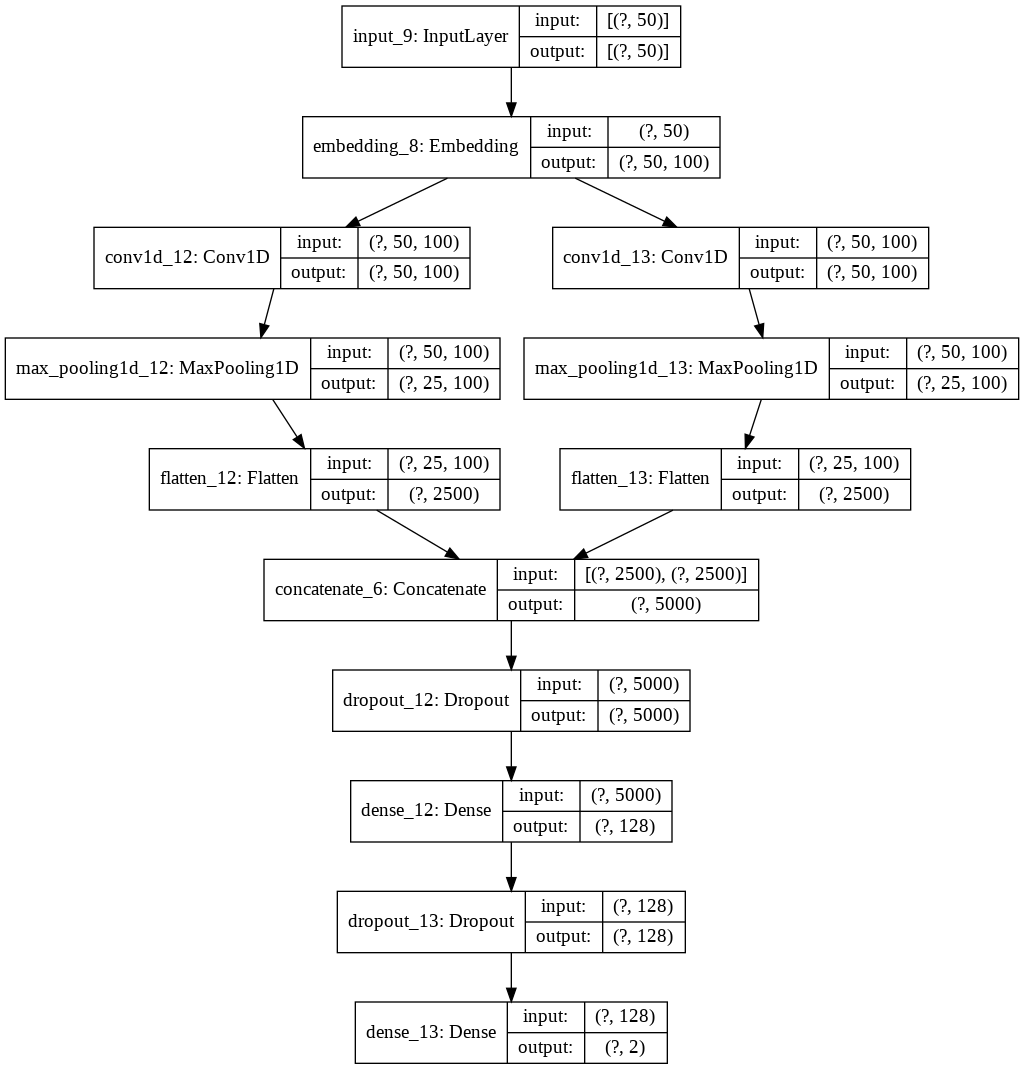

In [98]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model



Split the data into train and test

In [54]:
# Define a size for train set
train_size = int(0.5 * len(X))
# Split dataset 
train_X = X[:train_size]
test_X = X[train_size:]
train_Y = Y[:train_size]
test_Y = Y[train_size:]

Start training

In [ ]:
batch_size = 32
model.fit(train_X,train_Y, epochs = 12, batch_size=batch_size,validation_data=(test_X,test_Y))


Epoch 1/12
25000/25000 [==============================] - 2669s 107ms/step - loss: 0.4684 - accuracy: 0.7881 - val_loss: 0.4455 - val_accuracy: 0.8032
Epoch 2/12
 8894/25000 [=========>....................] - ETA: 27:56 - loss: 0.4096 - accuracy: 0.8244

Test the model on a validation set

In [58]:
validation_size = 10000
X_validate = test_X[-validation_size:]
Y_validate = test_Y[-validation_size:]
# X_test = X_test[:-validation_size]
# Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(x=test_X,y= np.array(test_Y), batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

 1943/25000 [=>............................] - ETA: 1:19 - loss: 0.4883 - accuracy: 0.7939

KeyboardInterrupt: ignored

Function to make predictions

In [71]:
def guess(twt):
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = twt
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=seq_length, dtype='int32', value=0)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    #print(sentiment)
    print("Confidence: " + str(sentiment[np.argmax(sentiment)]*100) + "%")
    if(np.argmax(sentiment) == 0):
        print("negative")
    elif (np.argmax(sentiment) == 1):
        print("positive")
    elif (np.argmax(sentiment) == 2):
        print("neutral")


In [96]:
guess("I'm very sad right now")

22/22 - 0s
Confidence: 66.49413108825684%
positive


In [90]:
data["Text"].values[6919]

'rubymaree idnt know how to do that  and i know you do '

In [91]:
Y[6919]

0.0

In [ ]:
model.save("model.h5")